In [2]:
import graspy
import numpy as np
from graspy.simulations import rdpg

In [3]:
def generateRDPG():
    n = 100
    X1 = np.zeros([n, 1])
    deltan = 20
    deltax = .1
    t = 12

    for i in range(n):
        X1[i] = np.random.uniform(0.2, 0.8)

    At = np.zeros([t, n, n])
    Xt = np.zeros([t, n])
    Z = np.r_[deltax*np.ones([deltan//2, 1]), -deltax*np.ones([deltan//2, 1]), np.zeros([n-deltan, 1])]

    for i in range(12):
        Xt[i] = np.squeeze(X1)
        if i == 5:
            Xt[i] = np.squeeze(X1+Z)
        elif i == 6: 
            Xt[i] = np.squeeze(X1-Z)
    
        At[i] = rdpg(np.c_[Xt[i], Xt[i]])
    
    return At

In [4]:
from rerf.urerf import UnsupervisedRandomForest
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomTreesEmbedding

(100, 1200)


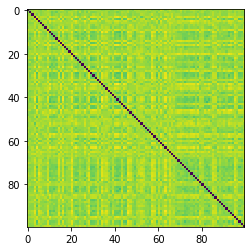

In [17]:
At = generateRDPG()
At_re = np.zeros((100, 1200))
for i in range(12):
    At_re[:, i*100:(i+1)*100] = At[i, :, :]
print(At_re.shape)
samples = np.diff(At_reshaped, axis=0)
clf = RandomTreesEmbedding(n_estimators=100, max_depth=40, random_state=0)
clf.fit(At_re)
n_sample = len(At_re)
n_estimator = len(clf.estimators_)
path = np.array(clf.decision_path(At_re)[0].todense())
depth = np.array((path*path).sum(1))
depth = np.tile(depth, (n_sample, 1))
depth = depth+depth.T
d = depth-2*path.dot(path.T)
d_sp = d / n_estimator

plt.imshow(d_sp)

([<matplotlib.axis.XTick at 0x7f7e9813e490>,
 <a list of 11 Text xticklabel objects>)

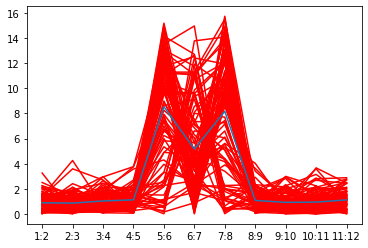

In [7]:
ys = np.zeros((100, 11))
for n_iter in range(100):
    At = generateRDPG()
    d = 2
    Vhat = np.zeros((100, 48))
    for i in range(12):
        ase = graspy.embed.AdjacencySpectralEmbed(n_components = 4)
        Vhat[:, 4*i:4*(i+1)] = ase.fit_transform(At[i])
    
    U, sigma, V = np.linalg.svd(Vhat)
    V = U[:, 0:d-1]
    Xhat = np.zeros((12, 100, d))
    for i in range(12):
        Rhat = V.T.dot(At[i]).dot(V)
        Xhat[i] = V.dot(Rhat)
    
    y = []
    for i in range(11):
        yhat = Xhat[i+1]-Xhat[i]
        y.append(np.linalg.norm(yhat))
    
    plt.plot(y, c='r')
    ys[n_iter] = np.array(y)

avg = np.mean(ys, axis=0)    
err = np.std(ys, axis=0)
plt.plot(avg)
plt.xticks(np.array(range(11)), ['1:2', '2:3', '3:4', '4:5', '5:6', '6:7', '7:8', '8:9', '9:10', '10:11', '11:12'])

([<matplotlib.axis.XTick at 0x7f7e82edd750>,
 <a list of 11 Text xticklabel objects>)

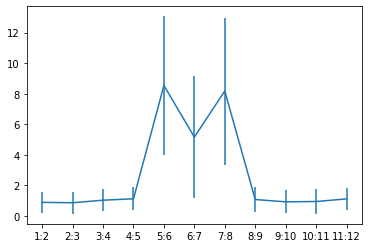

In [8]:
plt.errorbar(np.array(range(11)), avg, yerr=err)
plt.xticks(np.array(range(11)), ['1:2', '2:3', '3:4', '4:5', '5:6', '6:7', '7:8', '8:9', '9:10', '10:11', '11:12'])

([<matplotlib.axis.XTick at 0x7f7e80891550>,
 <a list of 11 Text xticklabel objects>)

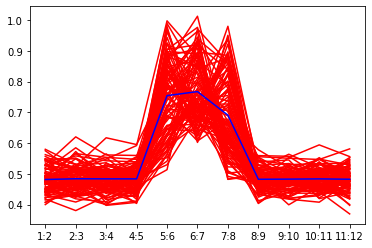

In [11]:
ys = np.zeros((100, 11))
for n_iter in range(100):
    At = generateRDPG()
    M = np.zeros((1200, 1200))
    for i in range(12):
        for j in range(12):
            M[i*100:(i+1)*100, j*100:(j+1)*100] = (At[i]+At[j])/2

    ase = graspy.embed.AdjacencySpectralEmbed(n_components=1)
    Xhat = ase.fit_transform(M)

    y = []
    for i in range(11):
        yhat = Xhat[(i+1)*100:(i+2)*100]-Xhat[i*100:(i+1)*100]
        y.append(np.linalg.norm(yhat))
    ys[n_iter] = np.array(y)
    plt.plot(y, c='r')
    
plt.plot(ys.mean(0), c='b')
plt.xticks(np.array(range(11)), ['1:2', '2:3', '3:4', '4:5', '5:6', '6:7', '7:8', '8:9', '9:10', '10:11', '11:12'])

([<matplotlib.axis.XTick at 0x7f7e80a1c5d0>,
 <a list of 11 Text xticklabel objects>)

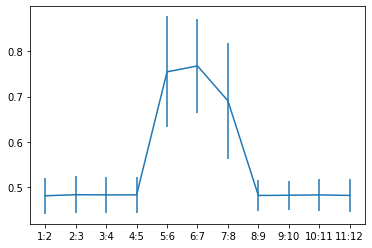

In [12]:
avg = np.mean(ys, axis=0)    
err = np.std(ys, axis=0)
plt.errorbar(np.array(range(11)), avg, yerr=err)
plt.xticks(np.array(range(11)), ['1:2', '2:3', '3:4', '4:5', '5:6', '6:7', '7:8', '8:9', '9:10', '10:11', '11:12'])

([<matplotlib.axis.XTick at 0x7f7e7b7b8dd0>,
 <a list of 12 Text xticklabel objects>)

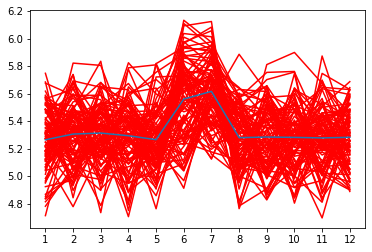

In [24]:
ys = np.zeros((100, 12))
for n_iter in range(100):
    At = generateRDPG()
    d = 2
    Vhat = np.zeros((100, 48))
    for i in range(12):
        ase = graspy.embed.AdjacencySpectralEmbed(n_components = 4)
        Vhat[:, 4*i:4*(i+1)] = ase.fit_transform(At[i])
    
    U, sigma, V = np.linalg.svd(Vhat)
    V = U[:, 0]
    Xhat = np.zeros((12, 100))
    for i in range(12):
        Rhat = V.T.dot(At[i]).dot(V)
        Xhat[i] = Rhat*V
    
    clf = RandomTreesEmbedding(n_estimators=100, max_depth=10, random_state=0)
    clf.fit(Xhat)
    n_sample = 12
    n_estimator = 100
    path = np.array(clf.decision_path(Xhat)[0].todense())
    depth = np.array((path*path).sum(1))
    depth = np.tile(depth, (n_sample, 1))
    depth = depth+depth.T
    d = depth-2*path.dot(path.T)
    d_sp = d / n_estimator
    
    y = d_sp.mean(0)
    
    plt.plot(y, c='r')
    ys[n_iter] = np.array(y)

avg = np.mean(ys, axis=0)    
err = np.std(ys, axis=0)
plt.plot(avg)
plt.xticks(np.array(range(12)), np.array(range(1, 13)))

([<matplotlib.axis.XTick at 0x7f7e7a891410>,
 <a list of 12 Text xticklabel objects>)

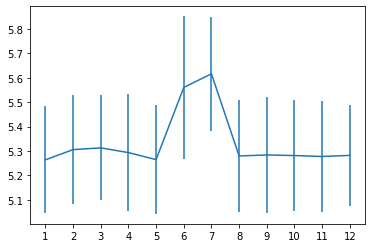

In [25]:
plt.errorbar(np.array(range(12)), avg, yerr=err)
plt.xticks(np.array(range(12)), np.array(range(1, 13)))